In [ ]:
import pandas as pd
from io import StringIO

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from statsmodels.stats.power import tt_ind_solve_power
from copy import deepcopy

In [ ]:
df = pd.read_csv('Контест_Аха_Самокат_тех_данные_по_мошенникам.csv', delimiter=';')
df.head(5)

,registration_date,activation_date,merchant_id,type,ind_frod
0,16.12.2023,24.12.2023,1,IE,0.0
1,05.09.2023,08.09.2023,2,IE,0.0
2,16.04.2023,22.04.2023,3,IE,0.0
3,23.12.2023,24.12.2023,4,IE,0.0
4,28.01.2023,NaN,5,IE,0.0


## preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   registration_date  35000 non-null  object 
 1   activation_date    20300 non-null  object 
 2   merchant_id        35000 non-null  int64  
 3   type               35000 non-null  object 
 4   ind_frod           34300 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.3+ MB


In [ ]:
cols_type = {
    'registration_date': 'datetime64[ns]',
    'activation_date': 'datetime64[ns]',
    'type': 'str'
}

df = df.astype(cols_type)
df.head(3)

<ipython-input-24-92a57eab13b3>:7: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = df.astype(cols_type)
<ipython-input-24-92a57eab13b3>:7: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = df.astype(cols_type)


,registration_date,activation_date,merchant_id,type,ind_frod
0,2023-12-16,2023-12-24,1,IE,0.0
1,2023-09-05,2023-09-08,2,IE,0.0
2,2023-04-16,2023-04-22,3,IE,0.0


In [ ]:
df['act_days'] = (df['activation_date'] - df['registration_date']).dt.days
df['is_activated'] = df['act_days'].notna().astype(int)
df.head(3)

,registration_date,activation_date,merchant_id,type,ind_frod,act_days,is_activated
0,2023-12-16,2023-12-24,1,IE,0.0,8.0,1
1,2023-09-05,2023-09-08,2,IE,0.0,3.0,1
2,2023-04-16,2023-04-22,3,IE,0.0,6.0,1


Посмотрим, есть ли аномальные значения по периоду активации

In [ ]:
df[(df.act_days > 100) | (df.registration_date < '2022-01-01')].sort_values(by='act_days')

,registration_date,activation_date,merchant_id,type,ind_frod,act_days,is_activated
34890,2023-08-23,2024-08-30,34891,LLC,0.0,373.0,1
7782,1970-01-01,2023-01-17,7783,IE,0.0,19374.0,1
22392,1970-01-01,2023-02-08,22393,IE,0.0,19396.0,1
28421,1970-01-01,2023-02-09,28422,LLC,NaN,19397.0,1
8744,1970-01-01,2023-02-09,8745,IE,1.0,19397.0,1
...,...,...,...,...,...,...,...
34217,1970-01-01,NaT,34218,LLC,0.0,NaN,0
34396,1970-01-01,NaT,34397,LLC,0.0,NaN,0
34415,1970-01-01,NaT,34416,LLC,0.0,NaN,0
34517,1970-01-01,NaT,34518,LLC,0.0,NaN,0


Тут явно что-то пошло не так с временем регистрации, исключим эти данные.

In [ ]:
df[df.act_days < 0].sort_values(by='act_days')

,registration_date,activation_date,merchant_id,type,ind_frod,act_days,is_activated
33774,2023-05-16,2022-05-20,33775,LLC,0.0,-361.0,1
31191,2023-01-15,2022-01-22,31192,LLC,1.0,-358.0,1
1007,2023-05-26,2022-06-03,1008,IE,0.0,-357.0,1
5249,2023-02-14,2022-02-23,5250,IE,0.0,-356.0,1
34995,2023-10-20,2022-10-31,34996,LLC,0.0,-354.0,1
3067,2023-08-03,2023-03-04,3068,IE,0.0,-152.0,1
31021,2023-06-29,2023-04-07,31022,LLC,1.0,-83.0,1
31282,2023-06-23,2023-04-26,31283,LLC,1.0,-58.0,1
31444,2023-10-11,2023-08-19,31445,LLC,0.0,-53.0,1
223,2023-07-02,2023-05-11,224,IE,0.0,-52.0,1


Тут тоже вероятно случились проблемы при заполнении. Например, у первых 5 строчек явно вместо 2023 заполнился 2022. Но, гадать мы не будем + такие ошибки единичны, так что аналогично исключим их из рассмотрения

In [ ]:
df_clean = df[
    ~(df['act_days'] < 0)
    & ~(df['act_days'] > 100)
    & (df.registration_date > '2022-01-01')
]
len(df), len(df_clean)

(35000, 34805)

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34805 entries, 0 to 34999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   registration_date  34805 non-null  datetime64[ns]
 1   activation_date    20194 non-null  datetime64[ns]
 2   merchant_id        34805 non-null  int64         
 3   type               34805 non-null  object        
 4   ind_frod           34107 non-null  float64       
 5   act_days           20194 non-null  float64       
 6   is_activated       34805 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 2.1+ MB


In [ ]:
df_clean['week'] = (
     df_clean['registration_date'].dt.year.astype('str')
     + '-'
     + df_clean['registration_date'].dt.isocalendar().week.astype('str')
)
df_clean['ind_frod'] = df_clean['ind_frod'].fillna(-1)

<ipython-input-30-db1863b820d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['week'] = (
<ipython-input-30-db1863b820d1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ind_frod'] = df_clean['ind_frod'].fillna(-1)


In [ ]:
stats_df = pd.DataFrame(df_clean[['type', 'ind_frod', 'is_activated']].value_counts()).reset_index().sort_values(by=['type', 'ind_frod', 'is_activated'])
stats_df.head(10)

,type,ind_frod,is_activated,count
8,IE,-1.0,0,210
6,IE,-1.0,1,286
1,IE,0.0,0,9326
0,IE,0.0,1,12894
5,IE,1.0,0,1001
4,IE,1.0,1,1362
11,LLC,-1.0,0,90
10,LLC,-1.0,1,112
3,LLC,0.0,0,3774
2,LLC,0.0,1,5303


In [ ]:
stats_df_ie

,type,ind_frod,is_activated,count
idx,,,,
fraud_unknown_no_act,IE,-1.0,0,210
fraud_unknown_act,IE,-1.0,1,286
no_fraud_no_act,IE,0.0,0,9326
no_fraud_act,IE,0.0,1,12894
fraud_no_act,IE,1.0,0,1001
fraud_act,IE,1.0,1,1362


In [ ]:
plt.set

Text(0.5, 0, 'Количество дней')

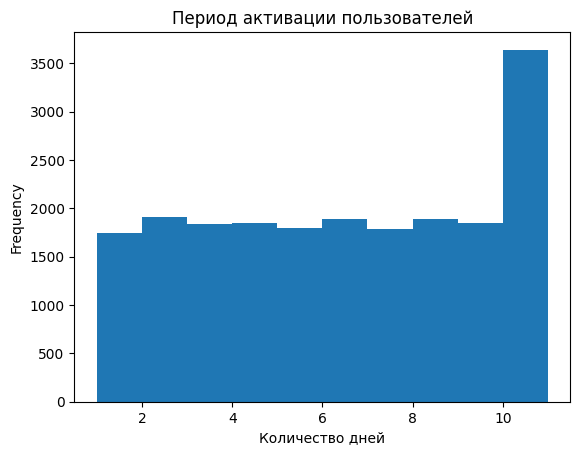

In [ ]:
df_clean['act_days'].plot(kind='hist')
plt.title('Период активации пользователей')
plt.xlabel('Количество дней')


In [ ]:
df_clean['act_days'].max()

11.0

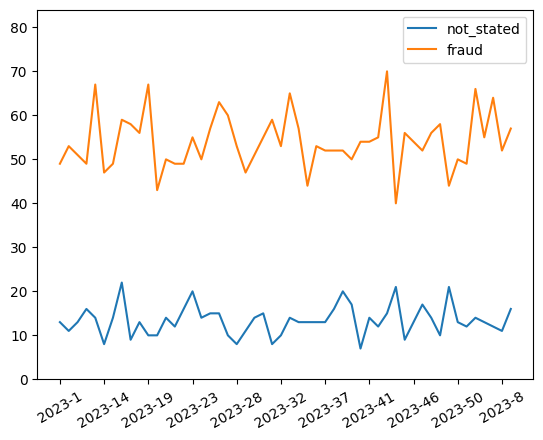

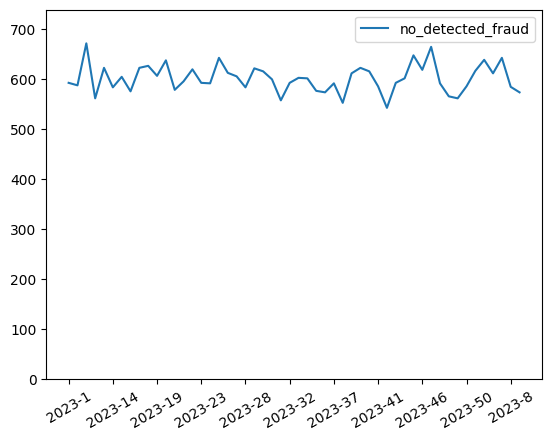

In [ ]:
df_stats = df_clean.groupby(['week', 'ind_frod'])[['registration_date']].count().reset_index(drop=False)
df_stats = df_stats.rename(columns={'registration_date': 'quantity'})
frod_dict = {-1:'not_stated', 0:'no_detected_fraud', 1:'fraud'}
xtickslist = df_stats['week'].unique()

for frod_type in [-1, 1]:
  df_frod_type = df_stats[df_stats['ind_frod'] == frod_type]
  plt.plot(df_frod_type['week'], df_frod_type['quantity'], label=frod_dict[frod_type])
plt.legend()
plt.ylim((0, max(df_frod_type.quantity) * 1.2))
plt.xticks(xtickslist[::5], rotation=30)
plt.show()

for frod_type in [0]:
  df_frod_type = df_stats[df_stats['ind_frod'] == frod_type]
  plt.plot(df_frod_type['week'], df_frod_type['quantity'], label=frod_dict[frod_type])
plt.legend()
plt.xticks(xtickslist[::5], rotation=30)
plt.ylim((0, max(df_frod_type.quantity) * 1.1))
plt.show()

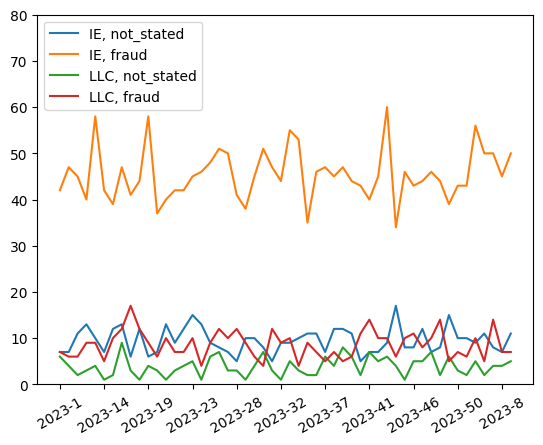

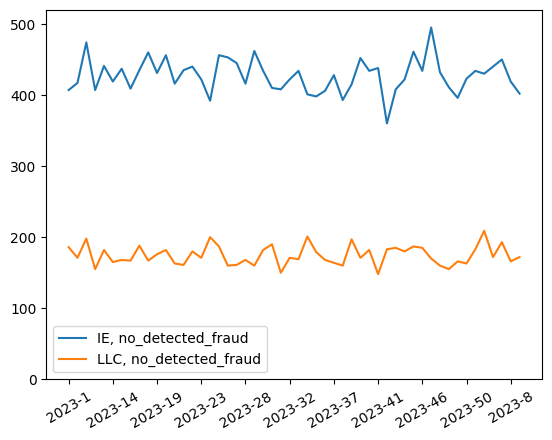

In [ ]:
df_stats = df_clean.groupby(['week', 'ind_frod', 'type'])[['registration_date']].count().reset_index(drop=False)
df_stats = df_stats.rename(columns={'registration_date': 'quantity'})
frod_dict = {-1:'not_stated', 0:'no_detected_fraud', 1:'fraud'}
xtickslist = df_stats['week'].unique()

for comp_type in df_stats['type'].unique():
  for frod_type in [-1, 1]:
    df_frod_type = df_stats[(df_stats['ind_frod'] == frod_type) & (df_stats['type'] == comp_type)]
    plt.plot(df_frod_type['week'], df_frod_type['quantity'], label=f'{comp_type}, {frod_dict[frod_type]}')
plt.legend()
plt.ylim((0, 80))
plt.xticks(xtickslist[::5], rotation=30)
plt.show()

for comp_type in df_stats['type'].unique():
  for frod_type in [0]:
    df_frod_type = df_stats[(df_stats['ind_frod'] == frod_type) & (df_stats['type'] == comp_type)]
    plt.plot(df_frod_type['week'], df_frod_type['quantity'], label=f'{comp_type}, {frod_dict[frod_type]}')
plt.legend()
plt.xticks(xtickslist[::5], rotation=30)
plt.ylim((0, 520))
plt.show()

In [ ]:
len(df_clean[df_clean['ind_frod'] == 1]) / len(df_clean)

0.08073552650481253

### Дизайн теста

In [ ]:
def choose_date_simple(data, start_date, delta, col='registration_date'):

  tmp = data[(data[col] >= start_date) &
              (data[col] < start_date + datetime.timedelta(days = delta)
              )]
  return tmp



def mde_getter_stratified(data, share, strata_name, col='registration_date'):

    days_list = list(range(7, df_clean['registration_date'].nunique(), 7))
    res = []
    for days in days_list:
        x1 = choose_date_simple(data = data, start_date = data[col].min(), delta = days)

        strata_mean = x1.groupby(strata_name)[['ind_frod']].mean()
        strata_std = x1.groupby(strata_name)[['ind_frod']].std()
        strata_p = x1.groupby(strata_name)[['ind_frod']].count()/x1.shape[0]
        regular_std = x1.ind_frod.std()

        stratified_std = np.sqrt((strata_std**2 * strata_p).sum())
        stratified_mean = (strata_mean*strata_p).sum()

        mean = stratified_mean
        std = stratified_std


        nobs1 = x1.shape[0]*1/(1 + share)

        alpha = 0.05
        power = 0.8
        # целевой размер относительного отклоенения исходной метрики
        # result_effect = 0.04
        # effect_size = (mean / std) * result_effect

        effect_size = tt_ind_solve_power(effect_size = None,
                                        alpha = alpha,
                                        power = power,
                                        nobs1 = nobs1,
                                        ratio = share,
                                        alternative = 'two-sided',
                                        )
        result_effect = effect_size / (mean / std)
        res.append(result_effect)

    return res

In [ ]:
strata_names = ['type']

# в нашем случае, фродер помеченный как "неизвестно" и как "не фродер" - одно и тоже
df_clean_non_neg = deepcopy(df_clean)
df_clean_non_neg['ind_frod'] = df_clean_non_neg['ind_frod'].replace(-1, 0)

res_df = pd.DataFrame(index = strata_names, columns = list(range(7, df_clean_non_neg['registration_date'].nunique(), 7)))

first_row = np.array(mde_getter_stratified(df_clean_non_neg, share = 1, strata_name = 'type')).reshape(1, -1)
res_df.loc['type', :] = first_row


res_df = res_df.T.reset_index()
res_df.columns = ['period_days', 'mde']
res_df.head(10)

,period_days,mde
0,7,0.76825
1,14,0.562393
2,21,0.450142
3,28,0.387289
4,35,0.349423
5,42,0.314367
6,49,0.284542
7,56,0.265679
8,63,0.248623
9,70,0.235462
